In [179]:
import nflgame
import mirofeatures as mf
import morefeatures as mf2
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ftrs2, isPass = mf.getFeatures(2009,2016) #get original feature set using nflgame API

In [169]:
df_ftrs = pd.DataFrame(ftrs2) #Process data into pandas dataframes
df_isPass = pd.DataFrame(isPass)
isPass =np.array(isPass)
df_ftrs.head(10) 
ftrs = np.array(ftrs2)

## Using a simple logistic classifier

To start, we have to drop the categorical features because they don't play well with linear classification. 

In [170]:
X = df_ftrs.drop(['opponent', 'team'], axis = 1) #Drops out opponent and team, cat variables 

We randomly mask our 238,599 data points so that we reserve some for testing the model

In [171]:
np.random.seed(12356) #Randomly seeded mask of the data, 3/4 for training, 1/4 for validation
mask = np.full(len(ftrs), False)
mask[:len(ftrs)*3/4] = True
np.random.shuffle(mask)

Fitting,

In [182]:
clf = linear_model.SGDClassifier(loss='log')
clf.fit(X[mask],isPass[mask])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [173]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*clf.score(X[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*clf.score(X[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 57.097274%
Success rate in predicting pass (for test data) is 57.232188%


In [183]:
mf2.cross_val(clf,X,isPass)

Cross validation accuracy with 10 folds is 0.56 (+/- 0.14)


Before modification: 57% ! Just based on logistic regression. There's also a huge amoung of variance based on what our cut (ie. how we mask the data) is.


In [10]:
np.sum(isPass)/float(len(isPass))

0.57018679877115996

Big surprise! For these seasons, about 57% of all plays are passes, so our naive classifier is only barely better than just always guessing "pass."

Let's compare to a decision tree that Ashwin/Tynan thought up (I know nothing about football so couldn't really help - Miro)

In [96]:
naive2 = [True for i in range(len(isPass))]
for i in range(len(isPass)):
    if df_ftrs['down'][i] == 1 and df_ftrs['togo'][i] <= 5:
        naive2[i] = False
    elif df_ftrs['down'][i] == 2 and df_ftrs['togo'][i] < 6:
        naive2[i] = False
    elif df_ftrs['down'][i] == 3 and df_ftrs['togo'][i] < 3:
        naive2[i] = False
    elif df_ftrs['down'][i] == 4 and df_ftrs['togo'][i] < 2:
        naive2[i] = False

In [97]:
print(np.sum(naive2==isPass)/float(len(isPass)))

0.589436669894


Linear regression just barely outperforms this!

<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

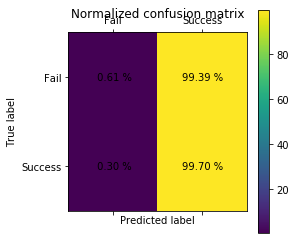

In [31]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], clf.predict(X[np.invert(mask)])))

## Using LDA (Linear Discriminant Analysis)

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [53]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X[mask],isPass[mask])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [35]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*lda_model.score(X[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*lda_model.score(X[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 70.746973%
Success rate in predicting pass (for test data) is 70.799665%


In [184]:
mf2.cross_val(lda_model,X,isPass)

Cross validation accuracy with 10 folds is 0.71 (+/- 0.02)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

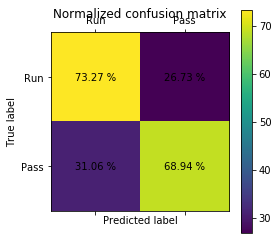

In [37]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], lda_model.predict(X[np.invert(mask)])))

## Using a tree based model

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf_model = RandomForestClassifier()
rf_model.fit(X[mask],isPass[mask])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf_model.score(X[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf_model.score(X[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 96.288887%
Success rate in predicting pass (for test data) is 66.546521%


In [185]:
mf2.cross_val(rf_model,X,isPass)

Cross validation accuracy with 10 folds is 0.66 (+/- 0.01)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

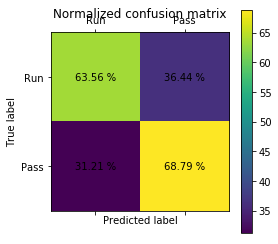

In [46]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], rf_model.predict(X[np.invert(mask)])))

Naively, seems like there is a substantial improvement in predicting play/pass. 66% is not terrible! But 96% training accuracy? Clearly some overfitting is happening here. Let's try dropping out time.


In [55]:
X2 = df_ftrs.drop(['opponent', 'team', 'time'], axis = 1)

In [56]:
rf_model2 = RandomForestClassifier()
rf_model2.fit(X2[mask],isPass[mask])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf_model2.score(X2[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf_model2.score(X2[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 76.202158%
Success rate in predicting pass (for test data) is 69.074602%


In [186]:
mf2.cross_val(rf_model2,X2,isPass)

Cross validation accuracy with 10 folds is 0.69 (+/- 0.01)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

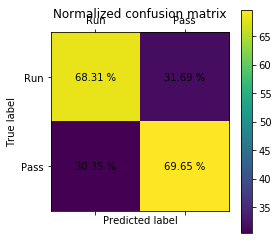

In [59]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], rf_model2.predict(X2[np.invert(mask)])))

Nice! We've increased test accuracy and looks like at least some of the overfitting for training data has been resolved. What if we include team and opponent?

## Expanding our feature set (and also changing data set to be 2002-2012 rather than 2009-2016)

Above this is largely simplistic exploration, below we do more complicated feature engineering.

Notebook will have a couple of problems here, because I will repeatedly restart while adding features. Append "n" to the variable names because it's a new dataset. Started with only the features above and have added: point difference,

In [434]:
nftrs2, nisPass2 = mf2.getAllFeatures() #Feature engineering code restricted to module

We will drop out the 2002 season so that our team stats can have a good start. Otherwise team pass/run stats would be relying on incomplete data, 

In [436]:
ndf_ftrs = pd.DataFrame(nftrs2)
ndf_isPass = pd.DataFrame(nisPass)
nisPass = np.array(nisPass2)

nisPass = nisPass[ndf_ftrs['season']!=2002]
ndf_ftrs = ndf_ftrs[ndf_ftrs['season']!=2002]
ndf_ftrs.head(10)

,def800,down,isHome,last800,lastPlay,lastszn,opponent,over7,ptdiff,quarter,season,shotgun,team,togo,togoal
33030,0.58375,1,True,0.53125,0,0.036657,NYJ,0,0,1,2003,0,WAS,10,71
33031,0.58375,2,True,0.53000,0,0.036657,NYJ,0,0,1,2003,0,WAS,7,68
33032,0.58375,3,True,0.52875,0,0.036657,NYJ,0,0,1,2003,0,WAS,2,63
33033,0.58375,1,True,0.52875,0,0.036657,NYJ,0,0,1,2003,0,WAS,10,59
33034,0.58375,2,True,0.52875,1,0.036657,NYJ,0,0,1,2003,0,WAS,6,55
33035,0.58375,3,True,0.52750,0,0.036657,NYJ,0,0,1,2003,0,WAS,4,53
33036,0.58375,2,True,0.52750,1,0.036657,NYJ,0,0,1,2003,0,WAS,17,54
33037,0.58375,1,True,0.52750,1,0.036657,NYJ,0,0,1,2003,0,WAS,10,29
33038,0.58375,2,True,0.52750,1,0.036657,NYJ,0,0,1,2003,0,WAS,9,28
33039,0.58500,4,True,0.52750,1,0.036657,NYJ,0,0,1,2003,0,WAS,13,32


In [437]:
nX = ndf_ftrs.drop(['opponent', 'team','togoal','season','last800','lastszn','lastPlay','over7','def800'], axis = 1)

#### RF fit without togoal, season, last800, lastszn, and lastPlay

In [307]:
np.random.seed(123456)
mask = np.full(len(ndf_ftrs), False)
mask[:len(ndf_ftrs)*3/4] = True
np.random.shuffle(mask)
rf_model3 = RandomForestClassifier()
rf_model3.fit(nX[mask],nisPass[mask])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [308]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf_model3.score(nX[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf_model3.score(nX[np.invert(mask)], nisPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 73.983957%
Success rate in predicting pass (for test data) is 70.069012%


In [189]:
mf2.cross_val(rf_model3,nX,nisPass)

Cross validation accuracy with 10 folds is 0.70 (+/- 0.08)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

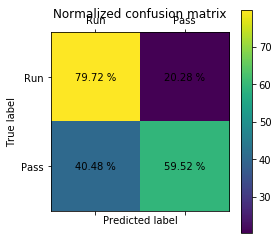

In [309]:
mf2.conf_m(confusion_matrix(nisPass[np.invert(mask)], rf_model3.predict(nX[np.invert(mask)])))

#### LDA fit without togoal, season, last800, lastszn, and lastPlay

In [310]:
nlda_model = LinearDiscriminantAnalysis()
nlda_model.fit(nX[mask],nisPass[mask])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [311]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*nlda_model.score(nX[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*nlda_model.score(nX[np.invert(mask)], nisPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 67.290472%
Success rate in predicting pass (for test data) is 67.377914%


In [312]:
mf2.cross_val(nlda_model,nX,nisPass)

Cross validation accuracy with 10 folds is 0.67 (+/- 0.12)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

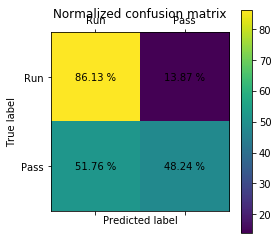

In [138]:
mf2.conf_m(confusion_matrix(nisPass[np.invert(mask)], nlda_model.predict(nX[np.invert(mask)])))

In [139]:
np.sum(nisPass)/float(len(nisPass))

0.47990260516252392

Many more runs in this dataset than the prior one? What gives? It's actually part of a broader trend towards more passing in the NFL. 

<img height=100 width=800 src="https://www.besttickets.com/blog/wp-content/uploads/2013/09/Rushing-Vs-Passing.png"></img>

### Adding team/historical data causes overfitting

In [369]:
X = ndf_ftrs.drop(['opponent', 'team','togoal','season','lastszn','last800'], axis = 1) #Keep the last 1 play

#### RF fit without togoal, season, last800, and lastszn (now includes lastplay)

In [320]:
np.random.seed(216216)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
rf4 = RandomForestClassifier()
rf4.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf4.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf4.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
mf2.cross_val(rf4,X,nisPass)


Success rate in predicting pass (for training data) is 75.174711%
Success rate in predicting pass (for test data) is 70.207522%
Cross validation accuracy with 10 folds is 0.70 (+/- 0.09)


In [194]:
np.random.seed(216216)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
lda3 = LinearDiscriminantAnalysis()
lda3.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*lda3.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*lda3.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
mf2.cross_val(lda3,X,nisPass)

Success rate in predicting pass (for training data) is 67.256669%
Success rate in predicting pass (for test data) is 67.593630%
Cross validation accuracy with 10 folds is 0.67 (+/- 0.11)


## Fine tuning parameters

We find that using 300 trees over the default 10 is helpful to get consistent 70% predictions

In [331]:
np.random.seed(216216)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
rf4 = RandomForestClassifier(n_estimators=300,max_features='auto')
rf4.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf4.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf4.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
#mf2.cross_val(rf4,X,nisPass)

Success rate in predicting pass (for training data) is 75.397862%
Success rate in predicting pass (for test data) is 70.493057%


Maybe we can fine tune to avoid some of the overfitting when it comes to season averages, last couple plays, etc. Also, switch to using all cores in parallel since this is a little more intensive.

TODO: Try different forest size (300 seems pretty good right now), max_features (using $\sqrt{n}$ right now), and tree depth. Also min_samples_split

In [440]:
X = ndf_ftrs.drop(['opponent', 'team','over7','def800'], axis = 1) #Keep the last 1 play

In [442]:
np.random.seed(1234)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
tuned = RandomForestClassifier(n_estimators=300,max_depth=13,n_jobs=-1)
tuned.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*tuned.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*tuned.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
#mf2.cross_val(tuned,X,nisPass)

Success rate in predicting pass (for training data) is 74.348508%
Success rate in predicting pass (for test data) is 73.006781%


Extra random forest doesn't do better (multiple randomized decision trees),

In [453]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators=200,max_depth=15,n_jobs=-1)
et.fit(X[mask],nisPass[mask])

print("Success rate in predicting pass (for training data) is %f%%" % (100*et.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*et.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
#mf2.cross_val(tuned,X,nisPass)

Success rate in predicting pass (for training data) is 74.328914%
Success rate in predicting pass (for test data) is 72.440811%


## While we still have more tuning, let's try some other models

We will now try **Gradient Tree Boosting** to try fix some of our overfitting problems. As a reminder, we have defined X:

In [443]:
X = ndf_ftrs.drop(['opponent', 'team'], axis = 1) #Keep the last 1 play

In [454]:
from sklearn.ensemble import GradientBoostingClassifier
np.random.seed(134)
params = {'n_estimators': 100, 'max_depth': 6}

gbt = GradientBoostingClassifier(**params)
gbt.fit(X[mask],nisPass[mask])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [456]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*gbt.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*gbt.score(X[np.invert(mask)], nisPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 73.836893%
Success rate in predicting pass (for test data) is 73.067967%


Text(0,0.5,u'Feature Importance Score')

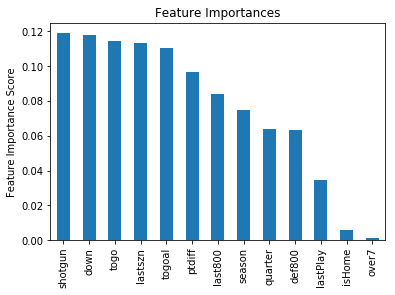

In [467]:
feat_imp = pd.Series(gbt.feature_importances_, list(X)).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Appendix: Exploration

Plotting the first two principal components from PCA, 

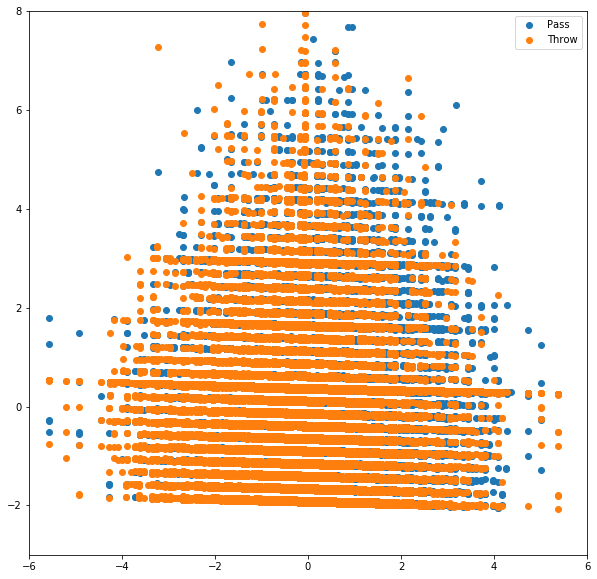

In [253]:
from sklearn.decomposition import PCA
X = ndf_ftrs.drop(['opponent', 'team','togoal','season','last800'], axis = 1) #Keep the last 1 play
pca = PCA(n_components=7, whiten=True)
pca.fit(X)
X_reduced =pca.transform(X)
plt.figure(figsize=(10,10))


plt.plot(X_reduced[:,0][nisPass==1],X_reduced[:,1][nisPass==1],'o', label='Pass')
plt.plot(X_reduced[:,0][nisPass==0],X_reduced[:,1][nisPass==0],'o', label='Throw')
plt.xlim((-6,6))
plt.ylim((-3,8))
plt.gca().legend()
plt.show()

## Success

In [363]:
np.random.seed(124)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
tuned = RandomForestClassifier(n_estimators=100,max_depth=15,n_jobs=-1)
tuned.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*tuned.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*tuned.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
mf2.cross_val(tuned,X,nisPass)

Success rate in predicting pass (for training data) is 74.884796%
Success rate in predicting pass (for test data) is 72.986386%
Cross validation accuracy with 10 folds is 0.72 (+/- 0.10)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
X = ndf_ftrs.drop(['opponent', 'team'], axis = 1) #Keep the last 1 play
np.random.seed(1234)
params = {'n_estimators': 100, 'max_depth': 5}

gbt = GradientBoostingClassifier(**params)
gbt.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*gbt.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*gbt.score(X[np.invert(mask)], nisPass[np.invert(mask)])))